In [1]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import folium
from folium.plugins import HeatMap, MarkerCluster, AntPath
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils, genetic_algo

In [21]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
# Read and Clean Data
spark = utils.start_spark()
df = utils.prepare_data(spark, data_path)
# Additional feature engineering - add more features
df = utils.feature_engineering(df)
columns_drop = ["AREA NAME", 
                "Rpt Dist No", 
                "Part 1-2", 
                "Crm Cd", 
                "Crm Cd Desc", 
                "Mocodes", 
                "Premis Cd",
                "Premis Desc",
                "Weapon Used Cd",
                "Weapon Desc",
                "Status Desc",
                "LOCATION",
                "age_group",
                "Date Rptd",
                "DATE OCC",
                "TIME OCC"]
df_dropped = utils.drop_columns(df, columns_drop)
df_clean = df_dropped.dropna(subset=["Vict Age"])

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 52911)
Traceback (most recent call last):
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12

In [22]:
df_clean.show()

+----+--------+--------+--------------------+------+-------+---------+-------------------+--------+---------+-------+------------------+
|AREA|Vict Age|Vict Sex|        Vict Descent|Status|    LAT|      LON|       Occ DateTime|Year OCC|Month OCC|Day OCC|          Category|
+----+--------+--------+--------------------+------+-------+---------+-------------------+--------+---------+-------+------------------+
|   1|      47|       M|               Other|    IC|34.0444|-118.2628|2020-02-08 18:00:00|    2020|        2|      8|              BTFV|
|   3|      19|       X|             Unknown|    IC| 34.021|-118.3002|2020-11-04 17:00:00|    2020|       11|      4|       OTHER THEFT|
|   9|      19|       M|               Other|    IC|34.1576|-118.4387|2020-03-10 20:37:00|    2020|        3|     10|       OTHER THEFT|
|   6|      28|       M|Hispanic/Latin/Me...|    IC|34.0944|-118.3277|2020-08-17 12:00:00|    2020|        8|     17|    IDENTITY THEFT|
|  18|      41|       M|Hispanic/Latin/Me

# Analysis by area
Since every precinct will define its own patrol routes and managing of crime. It would make sense to identify the hotspots by focusing on a certain area. Take for example the Downtown area which has been identified as the most densely reported crimes. We will analyse the crime in this area first. 

Downtown also Central is AREA code 1.

In [23]:
df_pd = df_clean.toPandas()
df_pd.head()

,AREA,Vict Age,Vict Sex,Vict Descent,Status,LAT,LON,Occ DateTime,Year OCC,Month OCC,Day OCC,Category
0,1,47,M,Other,IC,34.0444,-118.2628,2020-02-08 18:00:00,2020,2,8,BTFV
1,3,19,X,Unknown,IC,34.0210,-118.3002,2020-11-04 17:00:00,2020,11,4,OTHER THEFT
2,9,19,M,Other,IC,34.1576,-118.4387,2020-03-10 20:37:00,2020,3,10,OTHER THEFT
3,6,28,M,Hispanic/Latin/Mexican,IC,34.0944,-118.3277,2020-08-17 12:00:00,2020,8,17,IDENTITY THEFT
4,18,41,M,Hispanic/Latin/Mexican,IC,33.9467,-118.2463,2020-12-01 23:00:00,2020,12,1,IDENTITY THEFT


In [7]:
utils.stop_spark(spark)

In [24]:
df_clean_lat_lon = df_pd[(df_pd["LAT"]!=0.0)&(df_pd["LON"]!=0.0)]
df_clean_lat_lon[["LAT", "LON", "Category"]].groupby(["LAT", "LON"]).count().sort_values(by="Category", ascending=False)
df_clean_lat_lon[["AREA", "Category"]].groupby("AREA").count().sort_values(by="Category", ascending=False)

,Category
AREA,
1,50751
3,46727
12,45617
14,41072
6,38277
18,36078
15,35436
20,35432
7,34895


In [25]:
# take in the rest of the columns except the Datetime occ
columns = df_clean_lat_lon.columns.to_list()
columns.remove("Occ DateTime")
datatime_occ = df_clean_lat_lon["Occ DateTime"]
df_clustering = df_clean_lat_lon[columns]
print(datatime_occ.shape)
df_clustering.shape


(721201,)


(721201, 11)

In [26]:
# focusing on AREA 1 since AREA 1 has the highest crime frequencies reported
df_central = df_clustering[df_clustering["AREA"]==1]
print(df_central.shape)
# taking out the 2024 data as the reported crime seems to be incomplete
# the standard deviation of lag time in reporting is about 6 months
df_central = df_central[df_central["Year OCC"]!=2024]
print(df_central.shape)
df_central_encoded = pd.get_dummies(df_central, columns=["Vict Sex", "Vict Descent", "Status", "Category"], drop_first=True)
print(f"After 1-hot encoding we have {df_central_encoded.shape[1]} data features")


(50751, 11)
(46462, 11)
After 1-hot encoding we have 51 data features


Determining the eps using K-Nearest Neighbors (KNN)

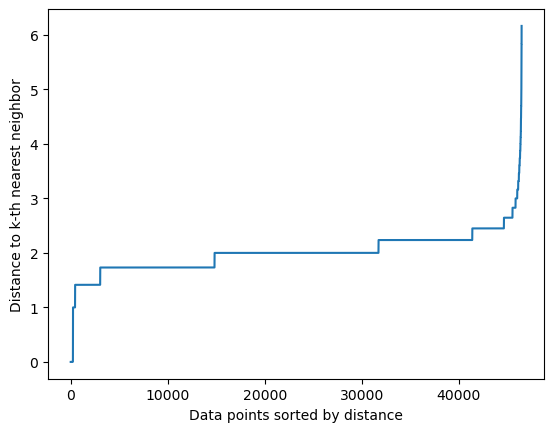

In [27]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Set the value of k as min_samples
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(df_central_encoded)
distances, indices = nbrs.kneighbors(df_central_encoded)
distances = np.sort(distances[:, k-1], axis=0)

plt.plot(distances)
plt.ylabel("Distance to k-th nearest neighbor")
plt.xlabel("Data points sorted by distance")
plt.show()

In [33]:
dbscan_central = DBSCAN(eps=3, min_samples = 5)
dbscan_clusters_central = dbscan_central.fit_predict(df_central_encoded)

In [36]:
dbscan_central_labels = dbscan_central.labels_
df_central_encoded["dbscan_clusters"] = dbscan_central_labels
# df_central_full = df_central_encoded
# df_central_full["datetime occ"] = datatime_occ
df_central_encoded[["LAT", "dbscan_clusters"]].groupby("dbscan_clusters").count()

,LAT
dbscan_clusters,
-1,483
0,45904
1,5
2,24
3,5
4,14
5,5
6,7
7,5


In [ ]:
# remove the ones with the -1 / noise
dbscan_central_hotspots = df_central_encoded[df_central_encoded["dbscan_clusters"]!=-1]


In [16]:
num_central_clusters = len(dbscan_central_hotspots['dbscan_clusters'].unique())
print(num_central_clusters)
print(dbscan_central_hotspots.shape)


25
(45322, 53)


In [17]:
dbscan_central_hotspots[["LAT", "dbscan_clusters"]].groupby("dbscan_clusters").count().sort_values(by="LAT", ascending=False)

,LAT
dbscan_clusters,
0,45175
12,15
11,10
15,9
1,9
22,8
2,7
21,7
7,7


In [18]:
dbscan_central_hotspots[["LAT", "LON", "dbscan_clusters"]].groupby(["LAT", "LON"]).count().sort_values(by="dbscan_clusters", ascending=False)

,,dbscan_clusters
LAT,LON,
34.0561,-118.2375,1030
34.0483,-118.2631,717
34.0421,-118.2469,656
34.0460,-118.2510,598
34.0480,-118.2577,562
...,...,...
34.0466,-118.2685,1
34.0589,-118.2414,1
34.0466,-118.2376,1


In [28]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[dbscan_central_hotspots['LAT'].mean(), dbscan_central_hotspots['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple', 'lightblue', 'lightgreen', 'gray', 'black']
marker_cluster = MarkerCluster().add_to(m)
# Add points to the map
for i, row in dbscan_central_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[int(row['dbscan_clusters']%10)],
        fill=True,
        fill_color=colors[int(row['dbscan_clusters']%10)],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(marker_cluster)

m.save('clusters_central_5_25_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')

In [19]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[dbscan_central_hotspots['LAT'].mean(), dbscan_central_hotspots['LON'].mean()], zoom_start=20)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray', 'red', 'blue', 'green', 'purple']
# Add points to the map
count = 0
for i, row in dbscan_central_hotspots.iterrows():
    count+=1
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=8,
        color=colors[int(row['dbscan_clusters']%10)],
        fill=True,
        fill_color=colors[int(row['dbscan_clusters']%10)],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(m)
print(count)

m.save('markers_central_5_25_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')


45322


In [31]:
# Only take the first 3 clusters and see how they end up
# top 3 clusters are 0, 1, 6
top_3_clusters = [0, 1, 6]
df_top3_central_hotspots = dbscan_central_hotspots[dbscan_central_hotspots["dbscan_clusters"].isin(top_3_clusters)]
df_top3_central_hotspots.shape

(19, 52)

In [32]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[df_top3_central_hotspots['LAT'].mean(), df_top3_central_hotspots['LON'].mean()], zoom_start=15)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add points to the map
for i, row in df_top3_central_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['dbscan_clusters']],
        fill=True,
        fill_color=colors[row['dbscan_clusters']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(m)

m.save('markers_central_top_3_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')


In [37]:
# Save the data for doing forecasting
dbscan_central_hotspots.to_pickle("area1_clusters.pkl")

# Forecast Crime with ARIMA


In [30]:
time_series_data = dbscan_central_hotspots.groupby(['datetime occ', 'dbscan_clusters']).size().unstack(fill_value=0)
time_series_data.head()

dbscan_clusters,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
datetime occ,,,,,,,,,,,,,,,,,,,,,
2022-08-06 02:40:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2022-08-06 14:02:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2022-08-06 14:59:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2022-08-06 16:50:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2022-08-06 19:25:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Iterate over each cluster
forecasts = {}
for cluster_id in time_series_data.columns:
    cluster_ts = time_series_data[cluster_id]

    # Check for stationarity
    result = adfuller(cluster_ts)
    print(result)
    if result[1] > 0.05:
        # Apply differencing if non-stationary
        cluster_ts = cluster_ts.diff().dropna()

    # Fit ARIMA model
    model = ARIMA(cluster_ts, order=(1, 1, 1))  # Order is an example, can be optimized
    fitted_model = model.fit()

    # Forecast future points
    forecast = fitted_model.forecast(steps=10)  # Forecasting the next 10 intervals
    forecasts[cluster_id] = forecast


(-2.9143440111332812, 0.04370523002239656, 8, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, -342.35104183417116)
(-2.8690728375850574, 0.04906441885521262, 12, 184, {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}, -355.7761734112232)
(-3.163450829439001, 0.02220018169910191, 10, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, -361.34870994266385)
(-3.277315862076729, 0.01592341065348518, 11, 185, {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}, -256.1370317170586)
(-3.277315862076749, 0.015923410653484214, 11, 185, {'1%': -3.4662005731940853, '5%': -2.8772932777920364, '10%': -2.575167750182615}, -256.1370317170584)
(-8.925042884745231, 1.016675031363399e-14, 15, 181, {'1%': -3.467004502498507, '5%': -2.8776444997243558, '10%': -2.575355189707274}, -592.4930832399102)
(-0.25760736803141815, 0.9312974969501042, 10, 186, {'1%': -3.4660050716

/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

(-3.9021923442408757, 0.0020187717711831455, 7, 189, {'1%': -3.4654311561944873, '5%': -2.8769570530458792, '10%': -2.574988319755886}, -150.92933419060972)
(-6.874791276980008, 1.4840685104371046e-09, 0, 196, {'1%': -3.464161278384219, '5%': -2.876401960790147, '10%': -2.5746921001665974}, -inf)
(-2.742448498330705, 0.06697642390714366, 9, 187, {'1%': -3.465811691080702, '5%': -2.877123351472649, '10%': -2.5750770662586864}, -339.4844244918122)
(-5.003224766539671, 2.1869317705544758e-05, 0, 196, {'1%': -3.464161278384219, '5%': -2.876401960790147, '10%': -2.5746921001665974}, -inf)
(-4.757872276725132, 6.542936258471978e-05, 5, 191, {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}, -217.02702038072897)
(-2.869072837585059, 0.04906441885521239, 12, 184, {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}, -355.776173411223)


/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been prov

(-2.8690728375850494, 0.04906441885521357, 12, 184, {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}, -355.7761734112232)
(-3.4567044475464486, 0.009171177841019451, 8, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, -237.18094673961338)
(-3.7812254752223575, 0.0031053509630214362, 8, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, -105.72311929943152)
(-3.163450829439003, 0.02220018169910183, 10, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, -361.34870994266385)
(-3.687835854808567, 0.004287543739930614, 10, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, -208.00480293759819)
(-3.983156765970083, 0.0015013212741933144, 8, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, -214.3973171911419)
(-2.4751362743158944, 0.1216417280862796, 11, 185, {'1%': -3.466200

/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been prov

(-2.742448498330706, 0.06697642390714355, 9, 187, {'1%': -3.465811691080702, '5%': -2.877123351472649, '10%': -2.5750770662586864}, -339.48442449181243)
(-2.8690728375850503, 0.04906441885521356, 12, 184, {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}, -355.7761734112232)
(-2.8690728375850534, 0.049064418855213114, 12, 184, {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}, -355.776173411223)
(-4.757872276725126, 6.542936258472182e-05, 5, 191, {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}, -217.02702038072897)
(-3.5940231445074735, 0.005876325839915885, 12, 184, {'1%': -3.466398230774071, '5%': -2.8773796387256514, '10%': -2.575213838610586}, -102.8217099314848)
(-0.20688919848025475, 0.9376954457735784, 5, 191, {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}, -414.32761021527654)
(-3.163450829438998, 0.022200181699102144, 10, 186, {'1%': -3.46600507165

/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is ava

In [35]:
for i in forecasts:
    print(forecasts[i])

197   -4.798059e-220
198   -4.798059e-220
199   -4.798059e-220
200   -4.798059e-220
201   -4.798059e-220
202   -4.798059e-220
203   -4.798059e-220
204   -4.798059e-220
205   -4.798059e-220
206   -4.798059e-220
Name: predicted_mean, dtype: float64
197    0.0
198    0.0
199    0.0
200    0.0
201    0.0
202    0.0
203    0.0
204    0.0
205    0.0
206    0.0
Name: predicted_mean, dtype: float64
197    0.0
198    0.0
199    0.0
200    0.0
201    0.0
202    0.0
203    0.0
204    0.0
205    0.0
206    0.0
Name: predicted_mean, dtype: float64
197   -6.500399e-67
198   -2.270103e-67
199   -5.023074e-67
200   -3.231509e-67
201   -4.397414e-67
202   -3.638672e-67
203   -4.132443e-67
204   -3.811109e-67
205   -4.020225e-67
206   -3.884138e-67
Name: predicted_mean, dtype: float64
197    4.600751e-30
198    1.606914e-30
199    3.555087e-30
200    2.287357e-30
201    3.112304e-30
202    2.575488e-30
203    2.924809e-30
204    2.697496e-30
205    2.845415e-30
206    2.749160e-30
Name: predicted_mean, 

# Some misc exploration

/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_6879/2937775353.py:3: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_top3_central_hotspots, x='LON', y='LAT', hue='dbscan_clusters', fill=True, alpha=0.5)
/var/folders/pf/n3d61f6d37g3nzd2rjz424b40000gn/T/ipykernel_6879/2937775353.py:3: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_top3_central_hotspots, x='LON', y='LAT', hue='dbscan_clusters', fill=True, alpha=0.5)


<Axes: xlabel='LON', ylabel='LAT'>

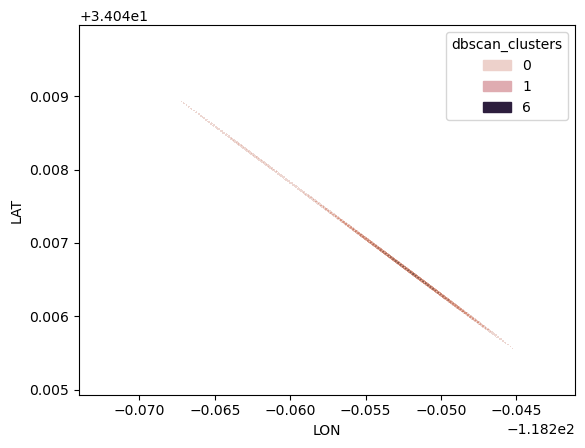

In [33]:
import seaborn as sns

sns.kdeplot(data=df_top3_central_hotspots, x='LON', y='LAT', hue='dbscan_clusters', fill=True, alpha=0.5)

# Route Identification with Genetic Algorithm
It would makes sense for the patrol routes to be identified based on area division. So we focus on the Central first. From the previous section we identified some hotspots. 

In [34]:
# the hotspots
central_hotspots = dbscan_central_hotspots[["LAT", "LON", "dbscan_clusters"]].groupby(["LAT", "LON"]).count().sort_values(by="dbscan_clusters", ascending=False).reset_index()
crime_hotspots = list(zip(central_hotspots["LAT"], central_hotspots["LON"]))
print(crime_hotspots)

[(34.0466, -118.252), (34.0483, -118.2631), (34.0423, -118.2561), (34.0461, -118.2475), (34.048, -118.2438), (34.0492, -118.2391), (34.0566, -118.2531), (34.0601, -118.2502), (34.0628, -118.2396)]


In [35]:
# Run the genetic algorithm
best_route, best_distance = genetic_algo.genetic_algorithm(crime_hotspots)
print("Best Route:", best_route)
print("Best Route Distance:", best_distance)

Generation 0, Best Distance: 8.25 km
Generation 10, Best Distance: 7.61 km
Generation 20, Best Distance: 7.61 km
Generation 30, Best Distance: 7.61 km
Generation 40, Best Distance: 7.61 km
Generation 50, Best Distance: 7.61 km
Generation 60, Best Distance: 7.61 km
Generation 70, Best Distance: 7.61 km
Generation 80, Best Distance: 7.61 km
Generation 90, Best Distance: 7.61 km
Generation 100, Best Distance: 7.61 km
Generation 110, Best Distance: 7.61 km
Generation 120, Best Distance: 7.61 km
Generation 130, Best Distance: 7.61 km
Generation 140, Best Distance: 7.61 km
Generation 150, Best Distance: 7.55 km
Generation 160, Best Distance: 7.55 km
Generation 170, Best Distance: 7.28 km
Generation 180, Best Distance: 7.28 km
Generation 190, Best Distance: 7.28 km
Generation 200, Best Distance: 7.28 km
Generation 210, Best Distance: 7.28 km
Generation 220, Best Distance: 7.28 km
Generation 230, Best Distance: 7.28 km
Generation 240, Best Distance: 7.28 km
Generation 250, Best Distance: 7.28 

In [36]:
route = [crime_hotspots[i] for i in best_route]
print(route)

[(34.0628, -118.2396), (34.0601, -118.2502), (34.0566, -118.2531), (34.0492, -118.2391), (34.048, -118.2438), (34.0466, -118.252), (34.0483, -118.2631), (34.0423, -118.2561), (34.0461, -118.2475)]


In [39]:
# Starting point for the map (centered on the first coordinate)
map_center = route[0]
m = folium.Map(location=map_center, zoom_start=14)

# Add the route to the map
AntPath(route, color="blue", weight=2.5, opacity=1).add_to(m)

# Add markers for each point
for i, (lat, lon) in enumerate(route, start=1):
    folium.Marker(
        location=(lat, lon),
        popup=f"Point {i}",  # Popup text shows the sequence number
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(m)
# Display map (if using Jupyter notebook, otherwise save to HTML)
m